# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import detect_sources
from scipy import stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from astroquery.gaia import Gaia
import pandas as pd
import subprocess
import shutil
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from pathlib import Path
from scipy.stats import siegelslopes
import seaborn as sns

# Load files

In [2]:
init_path = Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band")


solved_files = list(init_path.rglob("*.new"))

print(f"Found {len(solved_files)} solved files.")

for file in solved_files:
    with fits.open(file) as hdul:
        print(file.name, hdul[0].data.shape)

Found 10 solved files.
20260202T180749_464_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T180851_328_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T180923_002_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T181110_269_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T181320_905_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T181457_937_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T181609_569_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T181750_202_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T181944_118_StackInput_DarkSubtracted_g_band.new (488, 652)
20260202T182115_708_StackInput_DarkSubtracted_g_band.new (488, 652)


In [3]:
init_path = Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band")

fits_files = list(init_path.rglob("*.new"))

#print(f"Found {len(fits_files)} FITS files.")

rows = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header

            # Extract values safely (BIASLVL might not exist in all files)
            bias = header.get("BZERO")
            exptime = header.get("EXPTIME")
            gain = header.get("GAIN")

            obs_time = Time(header["DATE-OBS"], format="isot", scale="utc")

            location = EarthLocation(
                lat=header["LATITUDE"] * u.deg,
                lon=header["LONGITUD"] * u.deg,
                height=header.get("ALTITUDE", 0) * u.m
            )

            rows.append({
                "filename": file.name,
                "bias": bias,
                "exptime": exptime,
                "gain": gain,
                "obs_time": obs_time,
                "location": location
            })

    except Exception as e:
        print(f"Error reading {file.name}: {e}")

# Convert to DataFrame
df = pd.DataFrame(rows)

print(df.head())

                                            filename  bias   exptime  \
0  20260202T180749_464_StackInput_DarkSubtracted_...  None  3.971754   
1  20260202T180851_328_StackInput_DarkSubtracted_...  None  3.971754   
2  20260202T180923_002_StackInput_DarkSubtracted_...  None  3.971754   
3  20260202T181110_269_StackInput_DarkSubtracted_...  None  3.971754   
4  20260202T181320_905_StackInput_DarkSubtracted_...  None  3.971754   

       gain                 obs_time  \
0  0.128711  2026-02-02T18:07:45.492   
1  0.128711  2026-02-02T18:08:47.356   
2  0.128711  2026-02-02T18:09:19.030   
3  0.128711  2026-02-02T18:11:06.297   
4  0.128711  2026-02-02T18:13:16.933   

                                            location  
0  (3950552.8798473445, 502120.2027838626, 496563...  
1  (3950552.8798473445, 502120.2027838626, 496563...  
2  (3950552.8798473445, 502120.2027838626, 496563...  
3  (3950552.8798473445, 502120.2027838626, 496563...  
4  (3950552.8798473445, 502120.2027838626, 496563..

 ## Statistics of new image

In [4]:
fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band").rglob("*.new")

rows = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            data = hdul[0].data.astype(np.float32)

            mean, median, std = sigma_clipped_stats(data, sigma=3.0)
            mode = 3 * median - 2 * mean

            rows.append({
                "filename": file.name,
                "mean": mean,
                "median": median,
                "std": std,
                "mode": mode
            })

            print(f"{file.name}: "
                  f"Mean: {mean:.3f}, "
                  f"Median: {median:.3f}, "
                  f"Std: {std:.3f}, "
                  f"Mode: {mode:.3f} ADU")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
df_stats = pd.DataFrame(rows)

print("\nSummary:")
print(df_stats.head())

20260202T180749_464_StackInput_DarkSubtracted_g_band.new: Mean: 10441.425, Median: 10434.500, Std: 823.938, Mode: 10420.650 ADU
20260202T180851_328_StackInput_DarkSubtracted_g_band.new: Mean: 6914.309, Median: 6905.250, Std: 663.861, Mode: 6887.132 ADU
20260202T180923_002_StackInput_DarkSubtracted_g_band.new: Mean: 6904.349, Median: 6895.000, Std: 665.370, Mode: 6876.302 ADU
20260202T181110_269_StackInput_DarkSubtracted_g_band.new: Mean: 5106.555, Median: 5098.500, Std: 565.660, Mode: 5082.391 ADU
20260202T181320_905_StackInput_DarkSubtracted_g_band.new: Mean: 26964.855, Median: 26959.500, Std: 1327.195, Mode: 26948.789 ADU
20260202T181457_937_StackInput_DarkSubtracted_g_band.new: Mean: 27902.662, Median: 27896.500, Std: 1351.348, Mode: 27884.176 ADU
20260202T181609_569_StackInput_DarkSubtracted_g_band.new: Mean: 13151.696, Median: 13146.000, Std: 919.094, Mode: 13134.607 ADU
20260202T181750_202_StackInput_DarkSubtracted_g_band.new: Mean: 6596.059, Median: 6589.000, Std: 639.346, Mode:

## Use of DAOstars to find the stars inside new image coordinates

In [7]:
fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band").rglob("*.new")

all_sources = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header
            data = hdul[0].data.astype(np.float32)

        # Build WCS
        wcs = WCS(header)

        # Compute background stats
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        mode = 3 * median - 2 * mean

        # Star detection
        daofind = DAOStarFinder(fwhm=5.0, threshold=5.0 * std)
        sources = daofind(data - mode)

        if sources is None:
            print(f"No stars found in {file.name}")
            continue

        x = sources["xcentroid"]
        y = sources["ycentroid"]

        # Convert to RA/Dec
        ra, dec = wcs.all_pix2world(x, y, 0)

        image_coords = SkyCoord(ra=ra*u.deg,
                                dec=dec*u.deg,
                                frame="icrs")

        # Store everything
        for i in range(len(sources)):
            all_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_deg": float(ra[i]),
                "dec_deg": float(dec[i]),
                "skycoord": image_coords[i]
            })

        print(f"{file.name}: detected {len(sources)} stars")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
df_sources = pd.DataFrame(all_sources)

print("\nExtraction complete.")
print(df_sources.head())

20260202T180749_464_StackInput_DarkSubtracted_g_band.new: detected 96 stars
20260202T180851_328_StackInput_DarkSubtracted_g_band.new: detected 40 stars
20260202T180923_002_StackInput_DarkSubtracted_g_band.new: detected 139 stars
20260202T181110_269_StackInput_DarkSubtracted_g_band.new: detected 94 stars
20260202T181320_905_StackInput_DarkSubtracted_g_band.new: detected 13 stars
20260202T181457_937_StackInput_DarkSubtracted_g_band.new: detected 9 stars
20260202T181609_569_StackInput_DarkSubtracted_g_band.new: detected 21 stars
20260202T181750_202_StackInput_DarkSubtracted_g_band.new: detected 30 stars
20260202T181944_118_StackInput_DarkSubtracted_g_band.new: detected 27 stars
20260202T182115_708_StackInput_DarkSubtracted_g_band.new: detected 55 stars

Extraction complete.
                                            filename  x_centroid  y_centroid  \
0  20260202T180749_464_StackInput_DarkSubtracted_...  104.802456    2.973330   
1  20260202T180749_464_StackInput_DarkSubtracted_...  248.

In [8]:
# Run DAOStarFinder over bias-subtracted / WCS images and export results
fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band").rglob("*.new")


all_sources = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header
            data = hdul[0].data.astype(np.float32)

        # Build WCS
        wcs = WCS(header)

        # Compute background stats
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        mode = 3 * median - 2 * mean

        # Star detection
        daofind = DAOStarFinder(fwhm=5.0, threshold=5.0 * std)
        sources = daofind(data - mode)

        if sources is None:
            print(f"No stars found in {file.name}")
            continue

        x = sources["xcentroid"]
        y = sources["ycentroid"]

        # Convert to RA/Dec
        ra, dec = wcs.all_pix2world(x, y, 0)

        # Store everything
        for i in range(len(sources)):
            all_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_deg": float(ra[i]),
                "dec_deg": float(dec[i])
            })

        print(f"{file.name}: detected {len(sources)} stars")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
import pandas as pd

df_sources = pd.DataFrame(all_sources)

print("\nExtraction complete.")
print(df_sources.head())


20260202T180749_464_StackInput_DarkSubtracted_g_band.new: detected 96 stars
20260202T180851_328_StackInput_DarkSubtracted_g_band.new: detected 40 stars
20260202T180923_002_StackInput_DarkSubtracted_g_band.new: detected 139 stars
20260202T181110_269_StackInput_DarkSubtracted_g_band.new: detected 94 stars
20260202T181320_905_StackInput_DarkSubtracted_g_band.new: detected 13 stars
20260202T181457_937_StackInput_DarkSubtracted_g_band.new: detected 9 stars
20260202T181609_569_StackInput_DarkSubtracted_g_band.new: detected 21 stars
20260202T181750_202_StackInput_DarkSubtracted_g_band.new: detected 30 stars
20260202T181944_118_StackInput_DarkSubtracted_g_band.new: detected 27 stars
20260202T182115_708_StackInput_DarkSubtracted_g_band.new: detected 55 stars

Extraction complete.
                                            filename  x_centroid  y_centroid  \
0  20260202T180749_464_StackInput_DarkSubtracted_...  104.802456    2.973330   
1  20260202T180749_464_StackInput_DarkSubtracted_...  248.

## Plot to check the matched centroids

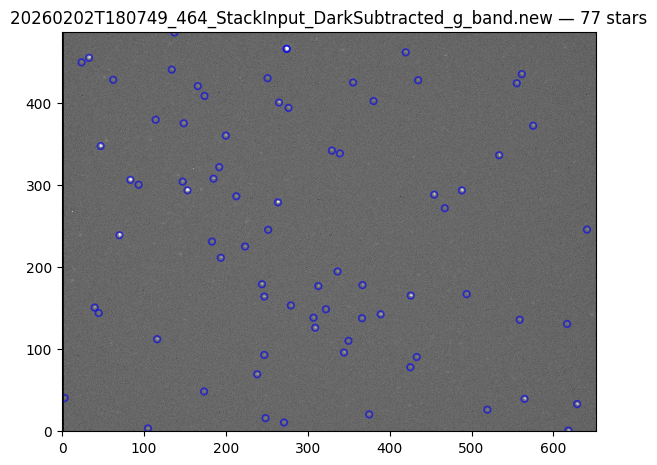

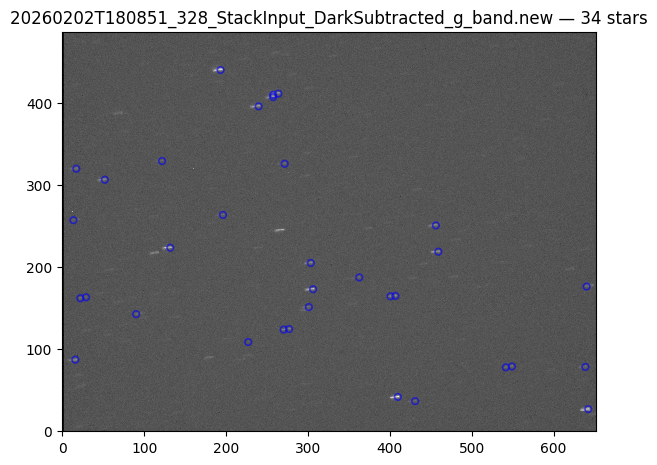

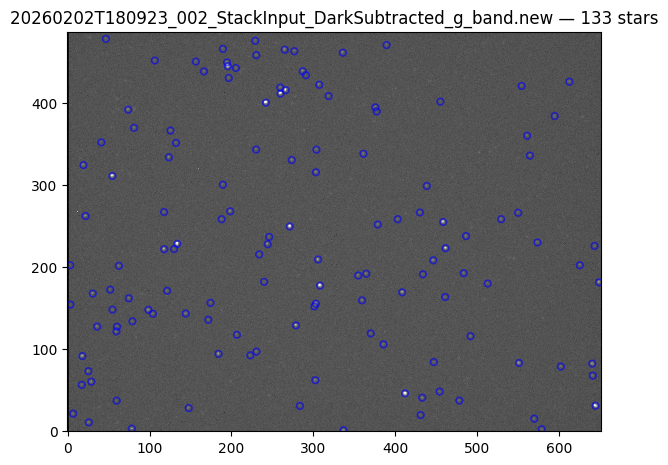

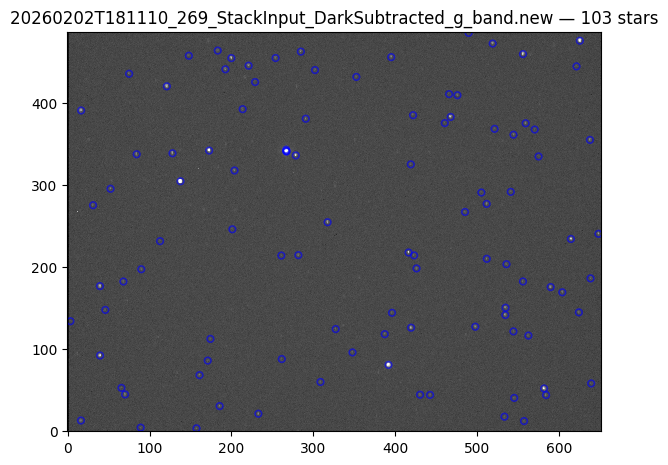

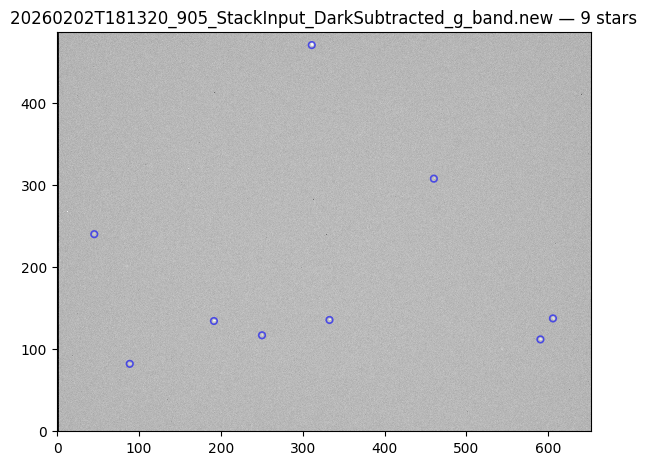

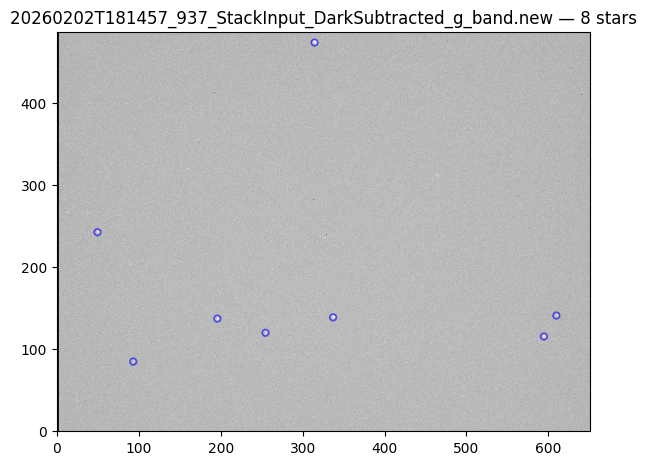

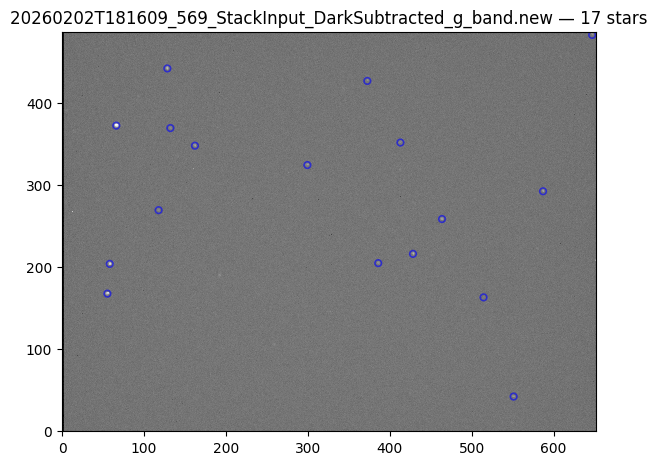

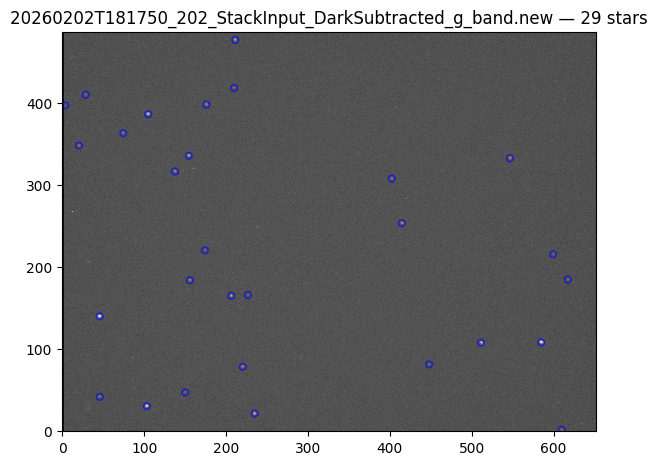

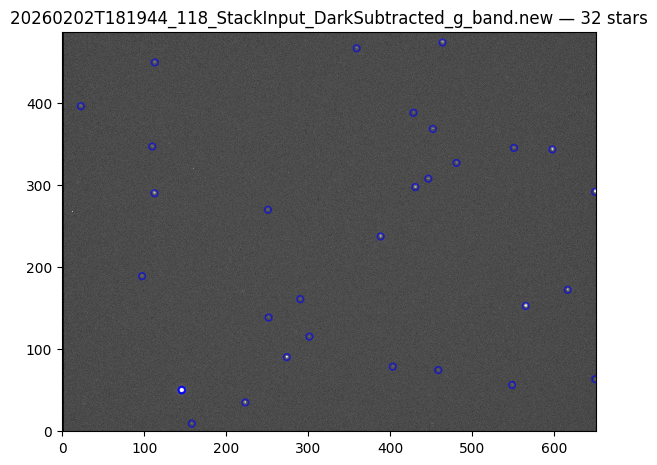

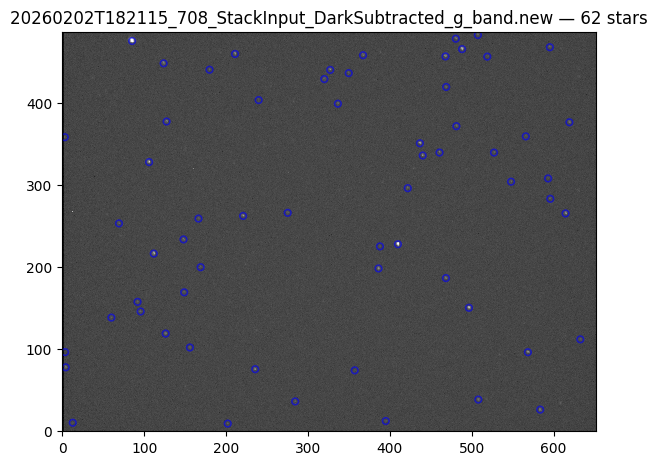

In [9]:
from photutils.aperture import CircularAperture


fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band").rglob("*.new")

for file in fits_files:

    with fits.open(file) as hdul:
        data = hdul[0].data.astype(np.float32)

    # Background stats
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    mode = 3 * median - 2 * mean

    # Detect stars
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = daofind(data - mode)

    if sources is None:
        print(f"No stars found in {file.name}")
        continue

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.0)

    # Plot
    plt.figure(figsize=(6, 5))
    norm = ImageNormalize(data, stretch=SqrtStretch())

    plt.imshow(data, cmap='gray', origin='lower',
               norm=norm, interpolation='nearest')

    apertures.plot(color='blue', lw=1.2, alpha=0.6)

    plt.title(f"{file.name} — {len(sources)} stars")
    plt.tight_layout()
    plt.show()

## Gaia extraction

In [10]:
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection=wcs)
# ax.imshow(data_wcs, origin='lower', cmap='gray', norm=norm)
# ax.set_xlabel('Right Ascension (J2000)')
# ax.set_ylabel('Declination (J2000)')
# ax.set_title('FITS Image with WCS')
# ax.grid(color='white', ls='dotted')
# plt.show()

In [11]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float32,float64,int64,float32,float32,float32,float64
1,201.9938633122364,8.88952913054978,0.6296686036712917,0.5240791,0.20707725736375285,25,4410.952,18098.805,-10.644125,-0.4830617892881061
2,12.701477879300027,9.931000157839554,0.6311746323278753,0.35939208,-0.026375384409839882,25,2917.4521,12555.304,-10.247068,-0.024734741376741608
3,394.9656561362402,12.040515718933896,0.7018299591210392,-0.101499364,-0.030445799288186873,25,5058.452,22553.305,-10.883025,-0.3854437289772325
4,583.5868297440987,25.943045040360712,0.48030433483714124,0.2518007,0.0008312240768947567,25,8060.952,52512.305,-11.8006525,-1.1441796100835793
5,284.3387807691263,35.927469658762604,0.5623246264365424,0.21949776,0.13188516140897727,25,9109.952,53878.805,-11.828546,-1.187874465974284
6,508.01234858695733,38.24392764546953,0.5932629566820409,-0.18140511,0.14383332445041455,25,7884.452,42028.805,-11.558867,-1.0365785248363442
7,357.0772684718534,73.89066131717584,0.7969494775261838,-0.0022032247,-0.15920515735309615,25,3339.4521,12183.304,-10.214413,-0.0048997707576253855
8,235.5508689850582,75.34363318459046,0.6956695686553144,-0.2566056,0.12329614038009495,25,13090.452,65587.805,-12.042057,-1.4786097074058784
9,4.184650316530414,77.58154915315143,0.6398273739979905,-0.4220362,0.26000354084811933,25,8385.452,48308.305,-11.710054,-1.0099814397073805


# Gaia crossmatch

In [12]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 10000

fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band").rglob("*.new")

matched_sources = []

# Loop over each bias-subtracted FITS image
for file in fits_files:

    # Open FITS
    with fits.open(file) as hdul:
        header = hdul[0].header
        data = hdul[0].data.astype(np.float32)

    # Build WCS
    wcs = WCS(header)

    # Background stats
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    mode = 3 * median - 2 * mean

    # Detect stars
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = daofind(data - mode)

    if sources is None:
        print(f"No stars found in {file.name}")
        continue

    x = sources["xcentroid"]
    y = sources["ycentroid"]
    flux = sources["flux"]
    mag_inst = sources["mag"]

    # Convert to RA/Dec
    ra, dec = wcs.all_pix2world(x, y, 0)
    image_coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

    # Gaia query
    center_coord = SkyCoord(np.mean(ra)*u.deg, np.mean(dec)*u.deg)
    radius = 0.4 * u.deg

    print(f"Querying Gaia for {file.name}...")
    job = Gaia.cone_search_async(coordinate=center_coord, radius=radius)
    gaia_table = job.get_results()

    if len(gaia_table) == 0:
        print(f"No Gaia sources found for {file.name}")
        continue

    gaia_coords = SkyCoord(ra=gaia_table["ra"], dec=gaia_table["dec"])

    # Cross-match image stars with Gaia
    idx, sep2d, _ = image_coords.match_to_catalog_sky(gaia_coords)
    max_sep = 2.0 * u.arcsec
    good_matches = sep2d < max_sep

    for i, match in enumerate(good_matches):
        if match:
            gaia_idx = idx[i]
            matched_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_image": float(ra[i]),
                "dec_image": float(dec[i]),
                "flux": float(flux[i]),
                "mag_inst": float(mag_inst[i]),
                "ra_gaia": gaia_table["ra"][gaia_idx],
                "dec_gaia": gaia_table["dec"][gaia_idx],
                "phot_g_mean_mag": gaia_table["phot_g_mean_mag"][gaia_idx],
                "separation_arcsec": sep2d[i].arcsec
            })

    print(f"{file.name}: {np.sum(good_matches)} matches found")

# Create DataFrame
df_matched = pd.DataFrame(matched_sources)
print(df_matched.head())

Querying Gaia for 20260202T180749_464_StackInput_DarkSubtracted_g_band.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T180749_464_StackInput_DarkSubtracted_g_band.new: 64 matches found
Querying Gaia for 20260202T180851_328_StackInput_DarkSubtracted_g_band.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T180851_328_StackInput_DarkSubtracted_g_band.new: 16 matches found
Querying Gaia for 20260202T180923_002_StackInput_DarkSubtracted_g_band.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T180923_002_StackInput_DarkSubtracted_g_band.new: 95 matches found
Querying Gaia for 20260202T181110_269_StackInput_DarkSubtracted_g_band.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T181110_269_StackInput_DarkSubtracted_g_band.new: 80 matches found
Querying Gaia for 20260202T181320_905_StackInput_DarkSubtracted_g_band.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T181320_905_StackInput_DarkSubtracted_g_band.new: 8 

In [4]:
df_matched.to_csv("matched_sources.csv", index=False)
df_matched['mag_inst']

NameError: name 'df_matched' is not defined

# Init from here

## Plot and fit of gaia stars magnitude and our stars magnitude

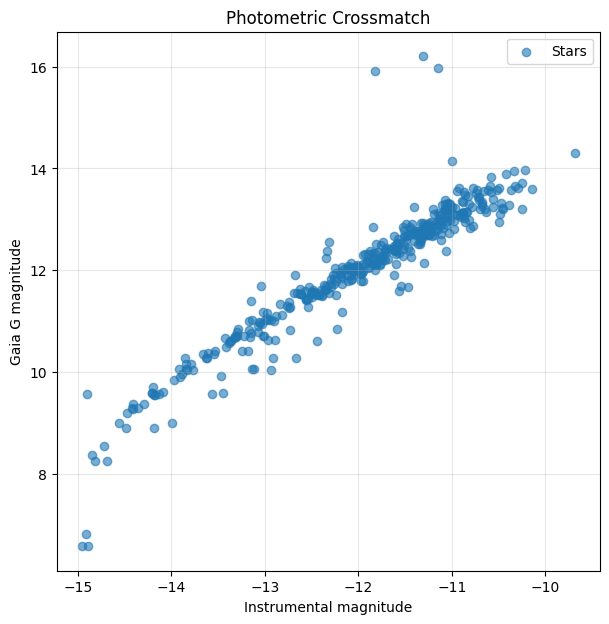

In [5]:
df_matched = pd.read_csv("matched_sources.csv")
plt.figure(figsize=(7,7))
plt.scatter(df_matched['mag_inst'], df_matched['phot_g_mean_mag'], alpha=0.6, label='Stars')
plt.xlabel("Instrumental magnitude")
plt.ylabel("Gaia G magnitude")
plt.title("Photometric Crossmatch")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Air mass calculation 


In [6]:
airmass_list = []
delta_m_list = []

# Path where the solved / dark_subtracted files live (defined earlier in the notebook)
init_path = Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band")

for filename in df_matched["filename"].unique():

    image_data = df_matched[df_matched["filename"] == filename]

    # Find the full file path for this filename under init_path
    matches = list(init_path.rglob(filename))
    if len(matches) == 0:
        print(f"File not found: {filename}")
        continue
    file_path = matches[0]

    with fits.open(file_path) as hdul:
        header = hdul[0].header

    obs_time = Time(header.get("DATE-OBS"), format="isot", scale="utc")

    # Some headers use LONGITUD or LONGITUDE; fall back safely
    lon_val = header.get("LONGITUD", header.get("LONGITUDE", 0))
    location = EarthLocation(
        lat=header.get("LATITUDE", 0) * u.deg,
        lon=lon_val * u.deg,
        height=header.get("ALTITUDE", 0) * u.m
    )

    # Rebuild sky coordinates from dataframe
    coords = SkyCoord(
        ra=image_data["ra_image"].values * u.deg,
        dec=image_data["dec_image"].values * u.deg
    )

    altaz_frame = AltAz(obstime=obs_time, location=location)
    altaz = coords.transform_to(altaz_frame)

    # Compute airmass robustly: sec(z) = 1 / cos(zenith_angle).
    # altaz.alt is the altitude; zenith_angle = 90deg - alt
    zenith = (90 * u.deg) - altaz.alt
    secz = 1.0 / np.cos(zenith.to(u.rad))
    X = secz.value

    # Remove bad airmass
    valid = (X > 1) & (X < 5)
    if not np.any(valid):
        continue

    delta_m = (-image_data["mag_inst"].values[valid] + image_data["phot_g_mean_mag"].values[valid])

    airmass_list.extend(X[valid])
    delta_m_list.extend(delta_m)

# Convert to arrays
airmass = np.array(airmass_list)
delta_m = np.array(delta_m_list)

print("Total stars used:", len(airmass))


Total stars used: 393


# From theory

$$m=-2.5\log{\left(\frac{F\times g}{t}\right)}+k\chi +Z_p$$

In [7]:
valid = np.isfinite(delta_m) & np.isfinite(airmass)

delta_m = delta_m[valid]
airmass = airmass[valid]

# 3-sigma clipping
mean = np.mean(delta_m)
std = np.std(delta_m)
clip = np.abs(delta_m - mean) < 3 * std

delta_m = delta_m[clip]
airmass = airmass[clip]

# linear fit
k, zp = np.polyfit(airmass, delta_m, 1)

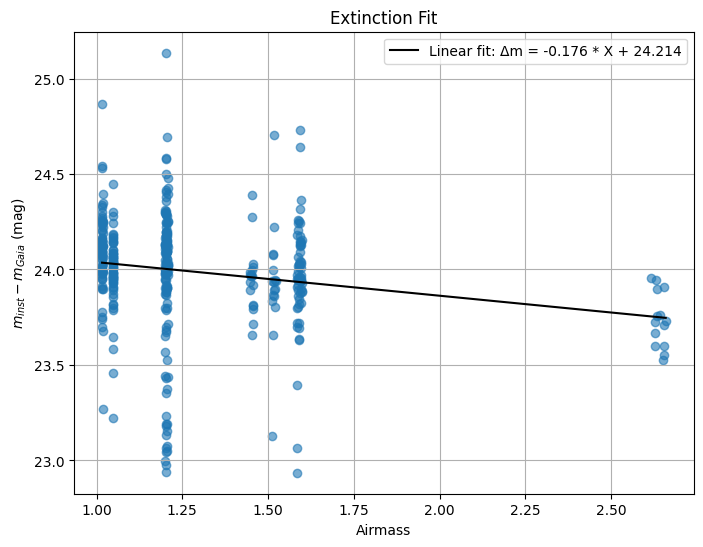

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(airmass, delta_m, alpha=0.6)
x_line = np.linspace(min(airmass), max(airmass), 100)
plt.plot(x_line, k*x_line + zp, 'k', label=f"Linear fit: Δm = {k:.3f} * X + {zp:.3f}")
plt.xlabel("Airmass")
plt.ylabel("$m_{inst} - m_{Gaia}$ (mag)")
plt.title("Extinction Fit")
plt.grid()
plt.legend()
plt.show()

#print("Extinction coefficient k =", k)
#print("Zero point ZP =", zp)


<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_975866/1176347467.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x_line, k*x_line + zp, 'C4', label=f"Linear fit: $Δm = {k:.3f}\chi + {zp:.3f}$")
/tmp/ipykernel_975866/1176347467.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.DataFrame({'airmass': airmass, 'delta_m': delta_m}).groupby(binned)


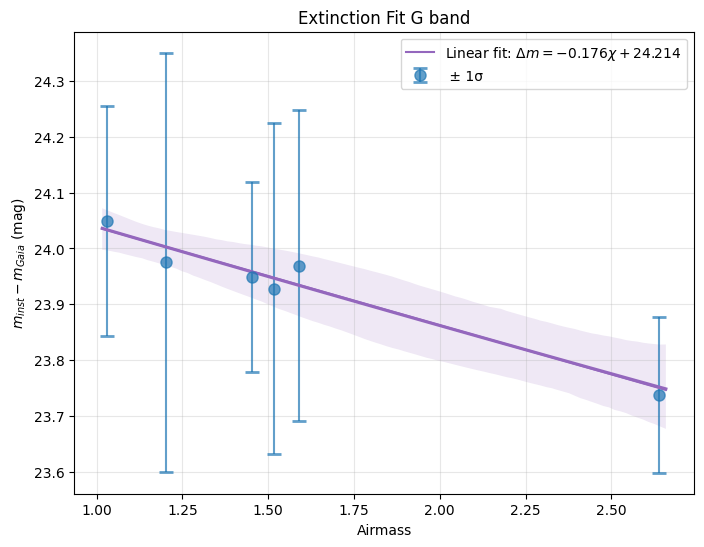

In [9]:
plt.figure(figsize=(8,6))

# Create bins for airmass and calculate mean and std for each bin
n_bins = 25
binned = pd.cut(airmass, bins=n_bins)
grouped = pd.DataFrame({'airmass': airmass, 'delta_m': delta_m}).groupby(binned)
bin_centers = grouped['airmass'].apply(np.mean)
bin_means = grouped['delta_m'].apply(np.mean)
bin_stds = grouped['delta_m'].apply(np.std)

# Plot error bars with points
plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', markersize=8, capsize=5, capthick=2, alpha=0.7, label=' ± 1σ')

# Add regression curve (quadratic) via seaborn
sns.regplot(x=airmass, y=delta_m, scatter=False, order=2, color='C4')

# Add linear fit from the earlier polyfit and label it
x_line = np.linspace(min(airmass), max(airmass), 100)
plt.plot(x_line, k*x_line + zp, 'C4', label=f"Linear fit: $Δm = {k:.3f}\chi + {zp:.3f}$")

plt.xlabel("Airmass")
plt.ylabel("$m_{inst} - m_{Gaia}$ (mag)")
plt.title("Extinction Fit G band")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Background substraction

In [18]:
# Compute background statistics (excluding source mask) and save to CSV
from astropy.stats import SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import sigma_clipped_stats

fits_dir = Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band")
fits_files = list(fits_dir.rglob("*.new"))
rows = []
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            data = hdul[0].data.astype(np.float32)
    except Exception as e:
        print(f'Error reading {file}: {e}')
        continue
    
    # Detect sources and build mask (True for source pixels)
    threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=5)
    if segment_img is None:
        mask = np.zeros_like(data, dtype=bool)
    else:
        footprint = circular_footprint(radius=15)
        mask = segment_img.make_source_mask(footprint=footprint)
    
    # Compute BACKGROUND stats (exclude source pixels via mask=True)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
    mode = 3 * median - 2 * mean
    masked_frac = float(np.count_nonzero(mask)) / mask.size
    rows.append({"filename": file.name, "bg_mean": float(mean), "bg_median": float(median), "bg_std": float(std), "bg_mode": float(mode), "masked_frac": masked_frac})

df_stats = pd.DataFrame(rows)
out_path = Path('g_band_stats_bkg.csv')
df_stats.to_csv(out_path, index=False)
df_stats

,filename,bg_mean,bg_median,bg_std,bg_mode,masked_frac
0,20260202T180749_464_StackInput_DarkSubtracted_...,10405.284180,10399.5,818.930237,10387.931641,0.295418
1,20260202T180851_328_StackInput_DarkSubtracted_...,6888.337891,6880.5,657.498718,6864.824219,0.249994
2,20260202T180923_002_StackInput_DarkSubtracted_...,6874.969727,6869.0,659.757629,6857.060547,0.424485
3,20260202T181110_269_StackInput_DarkSubtracted_...,5098.735352,5092.0,560.749451,5078.529297,0.331222
4,20260202T181320_905_StackInput_DarkSubtracted_...,26936.187500,26931.5,1323.723267,26922.125000,0.073472
5,20260202T181457_937_StackInput_DarkSubtracted_...,27881.041016,27874.0,1348.922729,27859.917969,0.062585
6,20260202T181609_569_StackInput_DarkSubtracted_...,13139.314453,13133.5,918.200134,13121.871094,0.089447
7,20260202T181750_202_StackInput_DarkSubtracted_...,6590.923340,6584.0,638.057861,6570.153320,0.107375
8,20260202T181944_118_StackInput_DarkSubtracted_...,5533.281738,5528.0,584.281860,5517.436523,0.123561
9,20260202T182115_708_StackInput_DarkSubtracted_...,4833.786133,4828.0,548.291199,4816.427734,0.220875


$$m_s = Z_p -2.5\log I_s$$

In [25]:
m_sky = zp - 2.5* np.log10((df_stats['bg_median']*0.12)/3.971754)
m_sky

0    17.971281
1    18.419762
2    18.421578
3    18.746591
4    16.938161
5    16.900814
6    17.717861
7    18.467588
8    18.657392
9    18.804394
Name: bg_median, dtype: float64

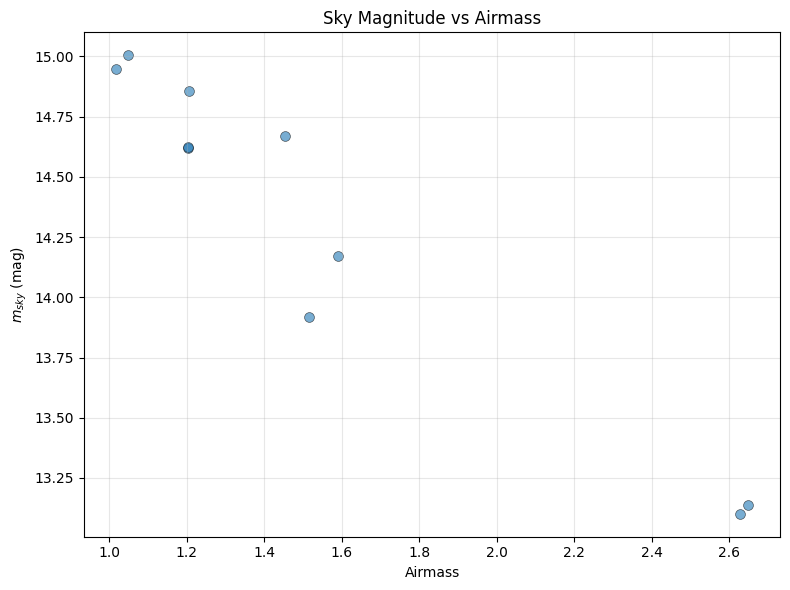

In [26]:
# Plot airmass vs m_sky
# m_sky = zp - 2.5 * log10(background_median)
# Pair each image's airmass with its sky magnitude

airmass_per_image = {}
for filename in df_matched["filename"].unique():
    image_data = df_matched[df_matched["filename"] == filename]
    init_path = Path("/mnt/c/Users/catal/Downloads/unistellar_observations/test_g_band")
    matches = list(init_path.rglob(filename))
    if len(matches) == 0:
        continue
    file_path = matches[0]
    
    with fits.open(file_path) as hdul:
        header = hdul[0].header
    
    obs_time = Time(header.get("DATE-OBS"), format="isot", scale="utc")
    lon_val = header.get("LONGITUD", header.get("LONGITUDE", 0))
    location = EarthLocation(lat=header.get("LATITUDE", 0) * u.deg, 
                             lon=lon_val * u.deg, 
                             height=header.get("ALTITUDE", 0) * u.m)
    
    coords = SkyCoord(ra=image_data["ra_image"].values * u.deg, 
                      dec=image_data["dec_image"].values * u.deg)
    altaz_frame = AltAz(obstime=obs_time, location=location)
    altaz = coords.transform_to(altaz_frame)
    zenith = (90 * u.deg) - altaz.alt
    secz = 1.0 / np.cos(zenith.to(u.rad))
    airmass_per_image[filename] = np.mean(secz.value)

# Load background stats CSV
df_bg_stats = pd.read_csv("g_band_stats.csv")

# Compute m_sky for each image
m_sky_values = []
airmass_values = []
for _, row in df_bg_stats.iterrows():
    filename = row["filename"]
    if filename in airmass_per_image:
        m_sky = zp - 2.5 * np.log10(row["bg_median"])
        m_sky_values.append(m_sky)
        airmass_values.append(airmass_per_image[filename])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(airmass_values, m_sky_values, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
plt.xlabel("Airmass")
plt.ylabel("$m_{sky}$ (mag)")
plt.title("Sky Magnitude vs Airmass")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()